In [ ]:
!nvidia-smi

Tue Apr 12 13:56:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow_datasets as tfds
import tensorflow_datasets.public_api as tfds
import matplotlib.pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_set, info = tfds.load('cifar10',split='train[:80%]',as_supervised=True, with_info=True)
valid_set = tfds.load('cifar10',split='train[80%:]',as_supervised=True)
test_set = tfds.load('cifar10',split='test',as_supervised=True)

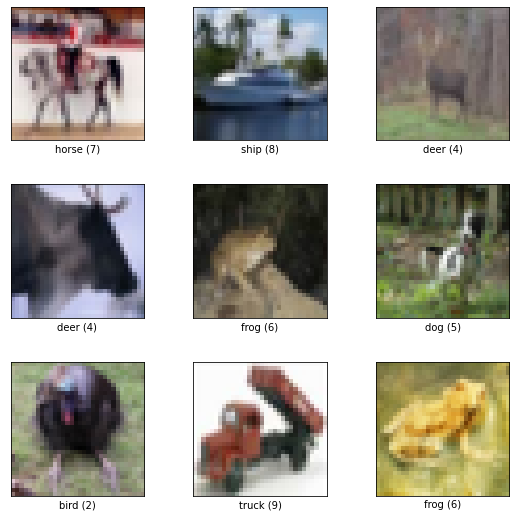

In [ ]:
#sample data 
fig = tfds.show_examples(train_set,info)

In [ ]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import DenseNet201, VGG16, VGG19, ResNet50, InceptionV3, DenseNet201, Xception, MobileNetV2, EfficientNetB5
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
def preprocess(image,label):
    
    image = tf.image.resize(image,[224,224])
    image = tf.cast(image,tf.float32)
    final_image = (image/255)

    return final_image, label

def augmentation(image,label):
    image = tf.image.resize(image,[224,224])
    image = tf.cast(image,tf.float32)
    image = (image/255)
    image = tf.image.random_flip_left_right(image)
    final_image = tfa.image.rotate(image,40,interpolation='NEAREST')

    return final_image, label

In [ ]:
batch_size = 64
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
for images, labels in test_set.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [ ]:
img_size = 224
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in base_model.layers[:-16]:
    layer.trainable = False 

last_layer = base_model.get_layer('block5_pool')
last_output = base_model.output

x = Flatten()(last_output)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

In [ ]:
filepath= "model_cnn_final.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)
early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
callbacks_list = [
        checkpoint,
        early_stopping,
    ]

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.0003), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
n_epochs = 15

history = model.fit(train_set,
    epochs=n_epochs,
    validation_data = valid_set,
    callbacks = callbacks_list
)

Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 1.2221 - accuracy: 0.5911
Epoch 1: val_loss improved from inf to 0.99381, saving model to model_cnn_final.h5
625/625 [==============================] - 127s 180ms/step - loss: 1.2221 - accuracy: 0.5911 - val_loss: 0.9938 - val_accuracy: 0.6658
Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.6990
Epoch 2: val_loss improved from 0.99381 to 0.88801, saving model to model_cnn_final.h5
625/625 [==============================] - 112s 179ms/step - loss: 0.9049 - accuracy: 0.6990 - val_loss: 0.8880 - val_accuracy: 0.6988
Epoch 3/15
625/625 [==============================] - ETA: 0s - loss: 0.8077 - accuracy: 0.7313
Epoch 3: val_loss improved from 0.88801 to 0.82617, saving model to model_cnn_final.h5
625/625 [==============================] - 112s 179ms/step - loss: 0.8077 - accuracy: 0.7313 - val_loss: 0.8262 - val_accuracy: 0.7225
Epoch 4/15
625/625 [==============================

In [ ]:
model.evaluate(test_set)

6/6 [==============================] - 1s 173ms/step - loss: 0.1926 - accuracy: 0.9328


[0.19258688390254974, 0.9327957034111023]

In [ ]:
y_truth = []
for sample in test_set:
  print(sample[1].numpy())
  y_truth += sample[1].numpy().tolist()
y_truth = np.array(y_truth)

[2 1 2 0 0 0 1 1 2 1 2 2 0 0 0 2 2 2 0 1 1 0 1 1 2 2 0 0 2 0 2 0 1 2 0 0 1
 0 2 2 2 1 2 1 1 2 2 1 0 2 0 2 0 1 2 1 1 2 2 1 1 2 0 2]
[0 1 1 1 2 1 0 2 0 1 1 0 1 0 0 1 0 2 2 1 2 0 0 1 2 0 2 2 2 0 0 1 1 2 0 2 0
 1 0 0 0 0 2 1 1 2 0 2 1 1 0 2 1 1 1 1 0 1 0 1 2 0 0 2]
[1 0 1 1 0 1 2 1 1 2 2 0 1 0 0 2 0 0 0 0 1 1 1 0 2 1 1 2 0 1 2 1 1 0 0 2 2
 2 0 1 2 2 0 2 2 0 0 0 2 0 2 1 2 1 0 1 2 2 2 0 1 1 2 2]
[2 1 1 0 1 2 0 1 2 1 0 2 1 1 1 0 0 1 0 0 0 1 2 1 2 1 1 0 2 2 2 2 0 1 0 0 0
 0 0 0 1 2 1 0 1 1 1 2 2 2 1 2 0 1 1 2 0 0 1 2 2 2 1 2]
[1 0 1 2 0 0 2 2 0 2 1 1 1 0 1 0 0 2 0 2 0 0 2 1 0 1 2 1 0 1 2 1 2 0 2 1 0
 0 1 1 0 1 0 1 0 1 1 2 0 0 0 2 1 0 1 2 1 0 2 2 2 0 0 1]
[0 2 0 2 1 0 2 2 2 1 2 2 1 1 2 2 1 0 2 2 0 2 1 1 0 0 1 2 2 0 0 2 2 2 0 2 2
 0 2 1 1 1 0 1 2 0 0 2 1 0 1 1]


In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(y_truth,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       124
           1       1.00      0.89      0.94       124
           2       0.89      0.91      0.90       124

    accuracy                           0.93       372
   macro avg       0.94      0.93      0.93       372
weighted avg       0.94      0.93      0.93       372



In [ ]:
a

In [ ]:
for images, labels in test_set.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

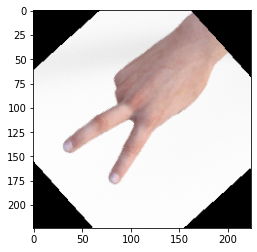

In [ ]:
plt.imshow(numpy_images[0])

In [ ]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)